# PyTorch vs Tensorflow

En este notebook vamos a llevar a cabo una comparativa de uso de las dos librerías principales de *Deep Learning*, Tensorflow y PyTorch.
Son muy similares aunque tienen ciertas diferencias tanto en la construcción del modelo como en su entrenamiento y explotación para inferencia.

## Funciones de activación

Las **funciones de activación** se aplican a la salida de cada neurona (o capa) en una red neuronal. Introducen no linealidad: sin ellas, apilar varias capas lineales equivaldría a una sola transformación lineal.

- **ReLU** (Rectified Linear Unit): \( f(x) = \max(0, x) \). Muy usada en capas ocultas. Cero para \(x \leq 0\), identidad para \(x > 0\). Rápida y evita el problema del gradiente que se desvanece en la zona positiva; en la zona negativa el gradiente es 0 (neurona “muerta”).

- **Sigmoid**: \( f(x) = 1 / (1 + e^{-x}) \). Salida en \((0, 1)\). Útil en la última capa para probabilidades (clasificación binaria). Sufre saturación y gradientes pequeños en los extremos.

- **Tanh**: \( f(x) = (e^x - e^{-x}) / (e^x + e^{-x}) \). Salida en \((-1, 1)\), centrada en cero. Mejor que sigmoid en capas ocultas en muchos casos, pero también puede saturarse.

- **Leaky ReLU**: \( f(x) = x \) si \(x > 0\), si no \(f(x) = \alpha x\) con \(\alpha\) pequeño (p. ej. 0.01). Evita que las neuronas con entrada negativa tengan gradiente exactamente 0, reduciendo el riesgo de “neuronas muertas”.

- **GELU** (Gaussian Error Linear Unit): aproximación suave que depende de la distribución de la entrada. Muy usada en modelos tipo Transformer (BERT, GPT).

- **Softmax**: convierte un vector de logits en probabilidades (suman 1). Se usa típicamente en la **última capa** para clasificación multiclase. No se suele representar en un eje \(x\) como las demás porque actúa sobre un vector.

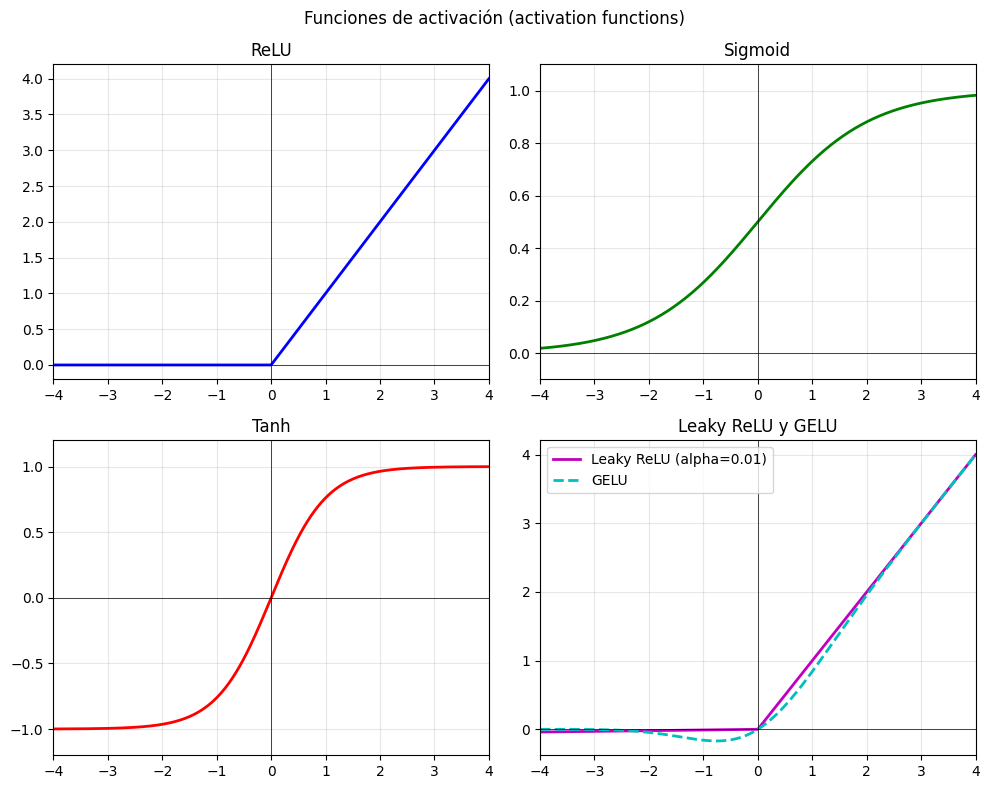

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Rango de entrada para graficar
x = np.linspace(-4, 4, 500)

# Definición de las funciones (equivalente a PyTorch/TensorFlow)
def relu(z):
    return np.maximum(0, z)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def tanh(z):
    return np.tanh(z)

def leaky_relu(z, alpha=0.01):
    return np.where(z > 0, z, alpha * z)

def gelu(z):
    # Aproximación común de GELU
    return 0.5 * z * (1 + np.tanh(np.sqrt(2/np.pi) * (z + 0.044715 * z**3)))

fig, axes = plt.subplots(2, 2, figsize=(10, 8))

axes[0, 0].plot(x, relu(x), 'b-', linewidth=2)
axes[0, 0].set_title('ReLU')
axes[0, 0].axhline(0, color='k', linewidth=0.5)
axes[0, 0].axvline(0, color='k', linewidth=0.5)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xlim(-4, 4)

axes[0, 1].plot(x, sigmoid(x), 'g-', linewidth=2)
axes[0, 1].set_title('Sigmoid')
axes[0, 1].axhline(0, color='k', linewidth=0.5)
axes[0, 1].axvline(0, color='k', linewidth=0.5)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim(-4, 4)
axes[0, 1].set_ylim(-0.1, 1.1)

axes[1, 0].plot(x, tanh(x), 'r-', linewidth=2)
axes[1, 0].set_title('Tanh')
axes[1, 0].axhline(0, color='k', linewidth=0.5)
axes[1, 0].axvline(0, color='k', linewidth=0.5)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlim(-4, 4)
axes[1, 0].set_ylim(-1.2, 1.2)

axes[1, 1].plot(x, leaky_relu(x), 'm-', linewidth=2, label='Leaky ReLU (alpha=0.01)')
axes[1, 1].plot(x, gelu(x), 'c--', linewidth=2, label='GELU')
axes[1, 1].set_title('Leaky ReLU y GELU')
axes[1, 1].axhline(0, color='k', linewidth=0.5)
axes[1, 1].axvline(0, color='k', linewidth=0.5)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim(-4, 4)

plt.suptitle('Funciones de activación (activation functions)', fontsize=12)
plt.tight_layout()
plt.show()

## Optimizadores y parámetros de entrenamiento

El **optimizador** es el algoritmo que actualiza los pesos de la red a partir de los gradientes de la función de pérdida. Los parámetros más importantes son:

- **learning_rate (lr)**: tamaño del paso en cada actualización. Un `lr` alto puede hacer que el entrenamiento sea inestable o diverja; uno muy bajo hace que converja muy lento.
- **momentum**: (en SGD) ayuda a suavizar las actualizaciones y escapar de mínimos locales; acumula una “inercia” en la dirección de gradientes recientes.
- **weight_decay**: regularización L2 sobre los pesos; penaliza pesos grandes.
- **betas** (en Adam): coeficientes para las medias de primer y segundo momento de los gradientes. Valores típicos: `(0.9, 0.999)`.

Algunos optimizadores habituales:

- **SGD** (Stochastic Gradient Descent): actualización básica; opcionalmente con `momentum` y `weight_decay`.
- **Adam**: adapta el learning rate por parámetro usando estimaciones del primer y segundo momento; suele converger rápido y es muy usado por defecto.
- **AdamW**: como Adam pero con desacoplo correcto de `weight_decay` (mejor para generalización en muchos casos).
- **RMSprop**: adapta el learning rate según la magnitud reciente de los gradientes; útil en RNN y cuando SGD con momentum no va bien.

A continuación se muestra un **ejemplo con PyTorch** de cómo el **learning_rate** afecta a la magnitud de los cambios en los pesos en un paso de entrenamiento.

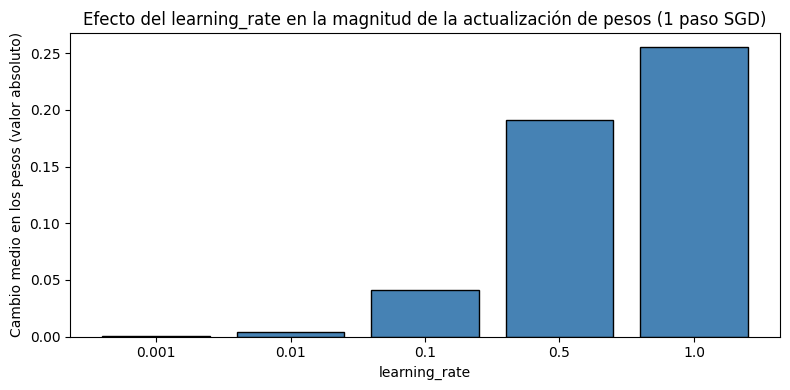

In [2]:
# Ejemplo: influencia del learning_rate en la actualización de los pesos (PyTorch)
import torch
import torch.nn as nn

# Red mínima: una capa lineal
model = nn.Sequential(nn.Linear(2, 3))
criterion = nn.MSELoss()

# Pesos iniciales (guardamos una copia para comparar)
with torch.no_grad():
    w0 = model[0].weight.clone()

# Entrada y objetivo ficticios
x = torch.tensor([[1.0, 2.0]])
y = torch.tensor([[0.5, 0.0, 0.5]])

# Probamos distintos learning_rate y medimos el cambio en los pesos tras un paso
learning_rates = [0.001, 0.01, 0.1, 0.5, 1.0]
weight_changes = []

for lr in learning_rates:
    model[0].weight.data = w0.clone()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer.zero_grad()
    loss = criterion(model(x), y)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        delta = (model[0].weight - w0).abs().mean().item()
    weight_changes.append(delta)

# Gráfica: a mayor learning_rate, mayores son los cambios en los pesos por paso
plt.figure(figsize=(8, 4))
plt.bar([str(lr) for lr in learning_rates], weight_changes, color='steelblue', edgecolor='black')
plt.xlabel('learning_rate')
plt.ylabel('Cambio medio en los pesos (valor absoluto)')
plt.title('Efecto del learning_rate en la magnitud de la actualización de pesos (1 paso SGD)')
plt.tight_layout()
plt.show()

### Comparación de optimizadores: SGD vs Adam

En el mismo paso de gradiente, **SGD** aplica el mismo `learning_rate` a todos los parámetros, mientras que **Adam** adapta el paso (escala) por parámetro. A continuación se compara la magnitud media del cambio en los pesos tras un paso, usando el mismo `lr=0.01`.

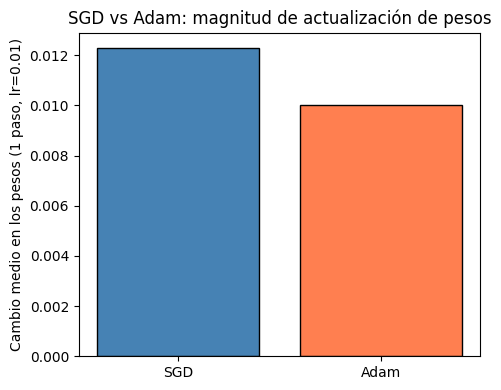

SGD  → cambio medio en pesos: 0.012278
Adam → cambio medio en pesos: 0.010000


In [3]:
# Mismo modelo, mismo lr, un paso: comparación SGD vs Adam
model_sgd = nn.Sequential(nn.Linear(2, 3))
model_adam = nn.Sequential(nn.Linear(2, 3))
with torch.no_grad():
    model_adam[0].weight.copy_(model_sgd[0].weight)
    model_adam[0].bias.copy_(model_sgd[0].bias)

lr = 0.01
opt_sgd = torch.optim.SGD(model_sgd.parameters(), lr=lr)
opt_adam = torch.optim.Adam(model_adam.parameters(), lr=lr)

criterion = nn.MSELoss()
x = torch.tensor([[1.0, 2.0]])
y = torch.tensor([[0.5, 0.0, 0.5]])

w_sgd_before = model_sgd[0].weight.clone()
opt_sgd.zero_grad()
loss_sgd = criterion(model_sgd(x), y)
loss_sgd.backward()
opt_sgd.step()
change_sgd = (model_sgd[0].weight - w_sgd_before).abs().mean().item()

w_adam_before = model_adam[0].weight.clone()
opt_adam.zero_grad()
loss_adam = criterion(model_adam(x), y)
loss_adam.backward()
opt_adam.step()
change_adam = (model_adam[0].weight - w_adam_before).abs().mean().item()

plt.figure(figsize=(5, 4))
plt.bar(['SGD', 'Adam'], [change_sgd, change_adam], color=['steelblue', 'coral'], edgecolor='black')
plt.ylabel('Cambio medio en los pesos (1 paso, lr=0.01)')
plt.title('SGD vs Adam: magnitud de actualización de pesos')
plt.tight_layout()
plt.show()
print(f"SGD  → cambio medio en pesos: {change_sgd:.6f}")
print(f"Adam → cambio medio en pesos: {change_adam:.6f}")

In [4]:
!pip install tensorflow tensorflow_datasets

  Obtaining dependency information for tensorflow_datasets from https://files.pythonhosted.org/packages/16/e0/657192dbc03636532ccbd5c90669d31a65187365b99ba685db36bb31dd67/tensorflow_datasets-4.9.9-py3-none-any.whl.metadata
  Obtaining dependency information for dm-tree from https://files.pythonhosted.org/packages/0d/ee/529ce999770b4d621a64af86c60cfee52f0cdd7294752105179ebf1c07c6/dm_tree-0.1.9-cp313-cp313-win_amd64.whl.metadata
  Obtaining dependency information for etils[edc,enp,epath,epy,etree]>=1.9.1 from https://files.pythonhosted.org/packages/e7/98/87b5946356095738cb90a6df7b35ff69ac5750f6e783d5fbcc5cb3b6cbd7/etils-1.13.0-py3-none-any.whl.metadata
  Obtaining dependency information for immutabledict from https://files.pythonhosted.org/packages/63/7b/04ab6afa1ff7eb9ccb09049918c0407b205f5009092c0416147d163e4e2b/immutabledict-4.2.2-py3-none-any.whl.metadata
  Using cached promise-2.3.tar.gz (19 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with 


[notice] A new release of pip is available: 23.2.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds

(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

C:\git\docencia\iniciacion_NLP_LLM\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Dl Completed...: 0 url [00:00, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|          | 0/1 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|          | 0/2 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|          | 0/3 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|          | 0/4 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|          | 0/4 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:  25%|██▌       | 1/4 [00:00<00:02,  1.30 url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Size...:   0%|          | 0/1 [00:00<?, ? MiB/s]

Dl Size...:   0%|          | 0/10 [00:00<?

Dataset mnist downloaded and prepared to C:\Users\frane\tensorflow_datasets\mnist\3.0.1. Subsequent calls will reuse this data.


In [6]:
28**2

784

In [7]:
import torch 
from torchvision import datasets, transforms
from torch.autograd import Variable

# download and transform train dataset
train_loader = torch.utils.data.DataLoader(datasets.MNIST('../mnist_data', 
                                                          download=True, 
                                                          train=True,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ])), 
                                           batch_size=128, 
                                           shuffle=True)

# download and transform test dataset
test_loader = torch.utils.data.DataLoader(datasets.MNIST('../mnist_data', 
                                                          download=True, 
                                                          train=False,
                                                          transform=transforms.Compose([
                                                              transforms.ToTensor(), # first, convert image to PyTorch tensor
                                                              transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                                          ])), 
                                           batch_size=128, 
                                           shuffle=True)

100%|██████████| 9.91M/9.91M [00:02<00:00, 3.68MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 316kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.43MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.27MB/s]


In [8]:
test_loader

# Construcción del modelo

## Tensorflow

In [12]:
model_tf = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(10)
])

model_tf.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

## PyTorch

In [13]:
import torch
import torch.nn as nn                     # neural networks
import torch.nn.functional as F           # layers, activations and more
import torch.optim as optim

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NNet(nn.Module):
    def __init__(self):
        super(NNet, self).__init__()
        self.flatten = nn.Flatten()
        self.model = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU())
        self.model_2 = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU())
        self.classifier = nn.Linear(64, 10)
            ## Softmax layer ignored since the loss function defined is nn.CrossEntropy()
        

    def forward(self, x):
        x = self.flatten(x)
        f1 = self.model(x)
        f2 = self.model_2(f1)
        logits = self.classifier(f2)
        #logits = self.model(x)
        return  logits

model_torch = NNet()

Using cpu device


In [14]:
print(model_torch)

NNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
  )
  (model_2): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
  )
  (classifier): Linear(in_features=64, out_features=10, bias=True)
)


# Parámetros de entrenamiento: optimizador, pérdida y métricas

## Tensorflow

In [15]:
# Definicion del optimizador (ADAM)
optimizer = tf.keras.optimizers.Adam(0.001)

# Función de pérdida
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Métricas
metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]

## PyTorch

In [16]:
# Función de pérdida
loss_torch = nn.CrossEntropyLoss()

# Definicion del optimizador (ADAM)
optimizer_torch = torch.optim.Adam(model_torch.parameters(), lr=0.001)

# Entrenamiento

## Tensorflow

In [17]:
model_tf.compile(
    optimizer= optimizer,
    loss=loss,
    metrics=metrics
)

model_tf.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)

Epoch 1/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3325 - sparse_categorical_accuracy: 0.9045 - val_loss: 0.1543 - val_sparse_categorical_accuracy: 0.9534
Epoch 2/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1325 - sparse_categorical_accuracy: 0.9601 - val_loss: 0.1116 - val_sparse_categorical_accuracy: 0.9668
Epoch 3/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0921 - sparse_categorical_accuracy: 0.9724 - val_loss: 0.0878 - val_sparse_categorical_accuracy: 0.9740
Epoch 4/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0691 - sparse_categorical_accuracy: 0.9793 - val_loss: 0.0874 - val_sparse_categorical_accuracy: 0.9725
Epoch 5/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0547 - sparse_categorical_accuracy: 0.9833 - val_loss: 0.0742 - val_sparse_categorical_accuracy: 0.9775
Epoch 6/6
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0445 - sparse_categorical_accuracy: 0.9859 - val_loss: 0.0730 - val_sparse_categorical_accuracy: 0.9774


## PyTorch

In [18]:
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter

def train(dataloader, model, loss_fn, optimizer):

    # Total size of dataset for reference
    size = 0

    # places your model into training mode
    model.train()

    # loss batch
    batch_loss = {}
    batch_accuracy = {}

    correct = 0
    _correct = 0



    # Gives X , y for each batch
    for batch, (X, y) in enumerate(dataloader):

        # Converting device to cuda
        X, y = X.to(device), y.to(device)
        model.to(device)

        # Compute prediction error / loss
        # 1. Compute y_pred
        # 2. Compute loss between y and y_pred using selectd loss function

        y_pred = model(X)
        loss = loss_torch(y_pred, y)

        # Backpropagation on optimizing for loss
        # 1. Sets gradients as 0
        # 2. Compute the gradients using back_prop
        # 3. update the parameters using the gradients from step 2

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _correct = (y_pred.argmax(1) == y).type(torch.float).sum().item()
        _batch_size = len(X)

        correct += _correct

        # Updating loss_batch and batch_accuracy
        batch_loss[batch] = loss.item()
        batch_accuracy[batch] = _correct/_batch_size

        size += _batch_size

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}]")

    correct/=size
    print(f"Train Accuracy: {(100*correct):>0.1f}%")

    return batch_loss , batch_accuracy

def validation(dataloader, model, loss_fn):
    
    # Total size of dataset for reference
    size = 0
    num_batches = len(dataloader)
    
    # Setting the model under evaluation mode.
    model.eval()

    test_loss, correct = 0, 0
    
    _correct = 0
    _batch_size = 0
    
    batch_loss = {}
    batch_accuracy = {}
    
    with torch.no_grad():
        
        # Gives X , y for each batch
        for batch , (X, y) in enumerate(dataloader):
            
            X, y = X.to(device), y.to(device)
            model.to(device)
            pred = model(X)
            
            batch_loss[batch] = loss_fn(pred, y).item()
            test_loss += batch_loss[batch]
            _batch_size = len(X)
            
            _correct = (pred.argmax(1) == y).type(torch.float).sum().item()
            correct += _correct
            
            size+=_batch_size
            batch_accuracy[batch] = _correct/_batch_size
            
            
            
    
    ## Calculating loss based on loss function defined
    test_loss /= num_batches
    
    ## Calculating Accuracy based on how many y match with y_pred
    correct /= size
    
    print(f"Valid Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return batch_loss , batch_accuracy

In [19]:
train_batch_loss = []
train_batch_accuracy = []
valid_batch_accuracy = []
valid_batch_loss = []
train_epoch_no = []
valid_epoch_no = []

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    _train_batch_loss , _train_batch_accuracy = train(train_loader, model_torch, loss_torch, optimizer_torch)
    _valid_batch_loss , _valid_batch_accuracy = validation(test_loader, model_torch, loss_torch)
    
    for i in range(len(_train_batch_loss)):
        train_batch_loss.append(_train_batch_loss[i])
        train_batch_accuracy.append(_train_batch_accuracy[i])
        train_epoch_no.append( t + float((i+1)/len(_train_batch_loss)))
    for i in range(len(_valid_batch_loss)):
        valid_batch_loss.append(_valid_batch_loss[i])
        valid_batch_accuracy.append(_valid_batch_accuracy[i])
        valid_epoch_no.append( t + float((i+1)/len(_valid_batch_loss)))
print("Done!")

Epoch 1
-------------------------------
loss: 2.319393  [    0]
loss: 0.332264  [12800]
loss: 0.167577  [25600]
loss: 0.295080  [38400]
loss: 0.140908  [51200]
Train Accuracy: 90.8%
Valid Error: 
 Accuracy: 95.2%, Avg loss: 0.153398 

Epoch 2
-------------------------------
loss: 0.095000  [    0]
loss: 0.110483  [12800]
loss: 0.209893  [25600]
loss: 0.262048  [38400]
loss: 0.109218  [51200]
Train Accuracy: 96.0%
Valid Error: 
 Accuracy: 96.7%, Avg loss: 0.107058 

Epoch 3
-------------------------------
loss: 0.098957  [    0]
loss: 0.126077  [12800]
loss: 0.175934  [25600]
loss: 0.152681  [38400]
loss: 0.105247  [51200]
Train Accuracy: 97.1%
Valid Error: 
 Accuracy: 97.1%, Avg loss: 0.098105 

Epoch 4
-------------------------------
loss: 0.049007  [    0]
loss: 0.045628  [12800]
loss: 0.142619  [25600]
loss: 0.046535  [38400]
loss: 0.041982  [51200]
Train Accuracy: 97.8%
Valid Error: 
 Accuracy: 97.5%, Avg loss: 0.080100 

Epoch 5
-------------------------------
loss: 0.052019  [   